In [2]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from time import sleep
from numpy import random
import time
plt.rcParams.update({'font.size': 16})
import mdptoolbox, mdptoolbox.example

In [5]:
# create Taxi environment
env = gym.make('Taxi-v3')

# create a new instance of taxi, and get the initial state
state = env.reset()

num_steps = 10
for s in range(num_steps+1):
    print(f"step: {s} out of {num_steps}")

    # sample a random action from the list of available actions
    action = env.action_space.sample()

    # perform this action on the environment
    env.step(action)

    # print the new state
    env.render()

# end this instance of the taxi environment
env.close()

step: 0 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
step: 1 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step: 2 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step: 3 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
step: 4 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
step: 5 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
step: 6 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step: 7 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step: 8 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+--------

In [12]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the enviorment every time when playing a new episode
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
#             enviorment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 20:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward

In [13]:
def one_step_lookahead(env, state, V , discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM Enviorment object
        state: state to consider
        V: Estimated Value for each state. Vector of length nS
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.nA)
    
    # loop over the actions we can take in an enviorment 
    for action in range(env.nA):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [14]:
def update_policy(env, policy, V, discount_factor):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to update.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-Value function 'V'.
    """
    
    for state in range(env.nS):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)
        
        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)
        
    return policy

In [15]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    
    # intialize value fucntion
    V = np.zeros(env.nS)
    
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_v = np.copy(V) 
    
        # loop over all states
        for state in range(env.nS):
            
            # Asynchronously update the state-action value
            action_values = one_step_lookahead(env, state, V, discount_factor)
            
            # Synchronously update the state-action value
#             action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            
            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            V[state] =  best_action_value
            
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
#                 print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

### Taxi 500 states

In [16]:
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",

('+---------+',)

### Value Iteration

In [17]:
print(0.9)  
rewards_vi=[]
run_time_vi=[]
itr_vi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_vi, opt_policy_vi = value_iteration(env.env, discount_factor = 0.9, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_vi, random = False)
    rewards_vi.append(avg_reward)
    run_time_vi.append(elapsed_time)
    itr_vi.append(i)
print(0.4)  
rewards_gamma_08_vi=[]
run_time_gamma_08_vi=[]
itr_gamma_08_vi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_08_vi, opt_policy_gamma_08_vi = value_iteration(env.env, discount_factor = 0.4, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_08_vi, random = False)
    rewards_gamma_08_vi.append(avg_reward)
    run_time_gamma_08_vi.append(elapsed_time)
    itr_gamma_08_vi.append(i)
print(0.6)      
rewards_gamma_06_vi=[]
run_time_gamma_06_vi=[]
itr_gamma_06_vi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_06_vi, opt_policy_gamma_06_vi = value_iteration(env.env, discount_factor = 0.6, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_06_vi, random = False)
    rewards_gamma_06_vi.append(avg_reward)
    run_time_gamma_06_vi.append(elapsed_time)
    itr_gamma_06_vi.append(i)
print(0.4)   
rewards_gamma_04_vi=[]
run_time_gamma_04_vi=[]
itr_gamma_04_vi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_04_vi, opt_policy_gamma_04_vi = value_iteration(env.env, discount_factor = 0.3, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_04_vi, random = False)
    rewards_gamma_04_vi.append(avg_reward)
    run_time_gamma_04_vi.append(elapsed_time)
    itr_gamma_04_vi.append(i)


0.9
0.4
0.6
0.4


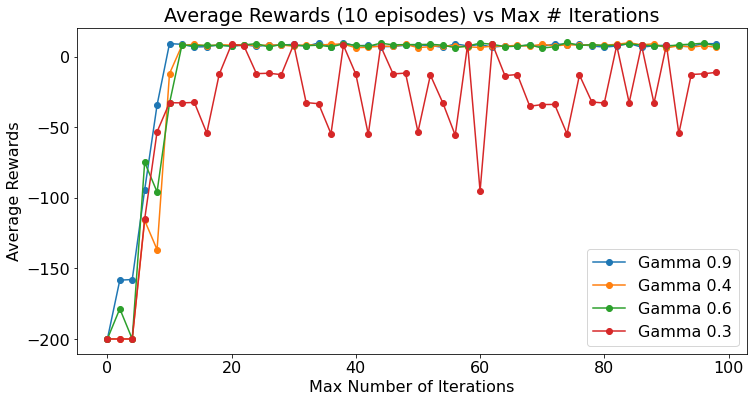

In [18]:
plt.plot(itr_vi,rewards_vi,marker='o', label='Gamma 0.9')
plt.plot(itr_vi,rewards_gamma_08_vi,marker='o', label='Gamma 0.4')
plt.plot(itr_vi,rewards_gamma_06_vi,marker='o', label='Gamma 0.6')
plt.plot(itr_vi,rewards_gamma_04_vi,marker='o', label='Gamma 0.3')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

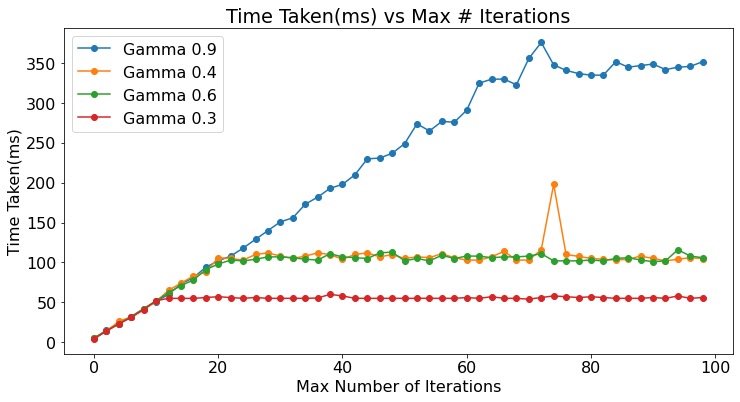

In [19]:
plt.plot(itr_vi,run_time_vi,marker='o', label='Gamma 0.9')
plt.plot(itr_vi,run_time_gamma_08_vi,marker='o', label='Gamma 0.4')
plt.plot(itr_vi,run_time_gamma_06_vi,marker='o', label='Gamma 0.6')
plt.plot(itr_vi,run_time_gamma_04_vi,marker='o', label='Gamma 0.3')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

In [20]:
env.reset()
opt_V, opt_policy_vi = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.9)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_vi, random = False)
print('Gamma:0.9')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.9
Total wins with value iteration: 10000
Average rewards with value iteration: 7.95


In [21]:
env.reset()
opt_V, opt_policy_gamma_08_vi = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.4)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_08_vi, random = False)
print('Gamma:0.4')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.4
Total wins with value iteration: 10000
Average rewards with value iteration: 7.9039


In [22]:
env.reset()
opt_V, opt_policy_gamma_06_vi = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.6)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_06_vi, random = False)
print('Gamma:0.6')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.6
Total wins with value iteration: 10000
Average rewards with value iteration: 7.8883


In [23]:
env.reset()
opt_V, opt_policy_gamma_04_vi = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.3)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_04_vi, random = False)
print('Gamma:0.3')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.3
Total wins with value iteration: 8665
Average rewards with value iteration: -19.3506


### Policy Iteration

In [24]:
def policy_eval(env, policy, V, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to evaluate.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state following a given policy and state-value 'V'. 
        
    """
    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [26]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        new_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize the state-Value function
    V = np.zeros(env.nS)
    
    # intialize a random policy
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        # evaluate given policy
        V = policy_eval(env, policy, V, discount_factor)
        
        # improve policy
        policy = update_policy(env, policy, V, discount_factor)
        
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
#                 print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
            

            
    return V, policy

In [27]:
print(0.9)  
rewards_pi=[]
run_time_pi=[]
itr_pi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V, opt_policy_pi = policy_iteration(env.env, discount_factor = 0.9, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_pi, random = False)
    rewards_pi.append(avg_reward)
    run_time_pi.append(elapsed_time)
    itr_pi.append(i)
print(0.4)  
rewards_gamma_08_pi=[]
run_time_gamma_08_pi=[]
itr_gamma_08_pi=[]
for i in range(0,100,2):
    env.reset()
    
    tic = time.time()
    opt_V_gamma_08_pi, opt_policy_gamma_08_pi = policy_iteration(env.env, discount_factor = 0.4, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_08_pi, random = False)
    rewards_gamma_08_pi.append(avg_reward)
    run_time_gamma_08_pi.append(elapsed_time)
    itr_gamma_08_pi.append(i)
print(0.6)      
rewards_gamma_06_pi=[]
run_time_gamma_06_pi=[]
itr_gamma_06_pi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_06, opt_policy_gamma_06_pi = policy_iteration(env.env, discount_factor = 0.6, max_iteration = i)
    toc = time.time()
    
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_06_pi, random = False)
    rewards_gamma_06_pi.append(avg_reward)
    run_time_gamma_06_pi.append(elapsed_time)
    itr_gamma_06_pi.append(i)
print(0.1)   
rewards_gamma_04_pi=[]
run_time_gamma_04_pi=[]
itr_gamma_04_pi=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_04, opt_policy_gamma_04_pi = policy_iteration(env.env, discount_factor = 0.1, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_04_pi, random = False)
    
    rewards_gamma_04_pi.append(avg_reward)
    run_time_gamma_04_pi.append(elapsed_time)
    itr_gamma_04_pi.append(i)

0.9
0.4
0.6
0.1


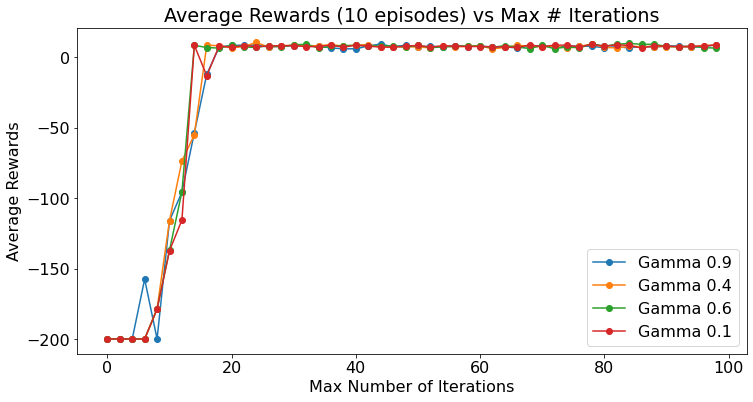

In [28]:
plt.plot(itr_pi,rewards_pi,marker='o', label='Gamma 0.9')
plt.plot(itr_pi,rewards_gamma_08_pi,marker='o', label='Gamma 0.4')
plt.plot(itr_pi,rewards_gamma_06_pi,marker='o', label='Gamma 0.6')
plt.plot(itr_pi,rewards_gamma_04_pi,marker='o', label='Gamma 0.1')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

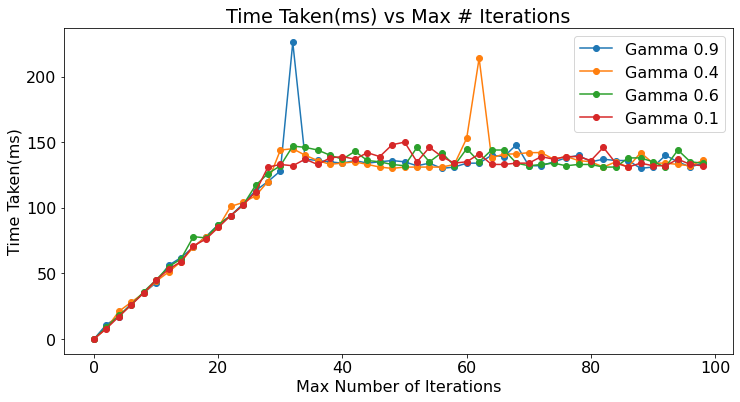

In [29]:
plt.plot(itr_pi,run_time_pi,marker='o', label='Gamma 0.9')
plt.plot(itr_pi,run_time_gamma_08_pi,marker='o', label='Gamma 0.4')
plt.plot(itr_pi,run_time_gamma_06_pi,marker='o', label='Gamma 0.6')
plt.plot(itr_pi,run_time_gamma_04_pi,marker='o', label='Gamma 0.1')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

In [30]:
env.reset()
opt_V, opt_policy_pi = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.9)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_pi, random = False)
print('Gamma:0.9')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.9
Total wins with value iteration: 10000
Average rewards with policy iteration: 7.9119


In [31]:
env.reset()
opt_V, opt_policy_gamma_08_pi = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.4)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_08_pi, random = False)
print('Gamma:0.4')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.4
Total wins with value iteration: 10000
Average rewards with policy iteration: 7.9191


In [32]:
env.reset()
opt_V, opt_policy_gamma_06_pi = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.6)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_06_pi, random = False)
print('Gamma:0.6')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.6
Total wins with value iteration: 10000
Average rewards with policy iteration: 7.9825


In [33]:
env.reset()
opt_V, opt_policy_gamma_04_pi = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.3)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_04_pi, random = False)
print('Gamma:0.3')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.3
Total wins with value iteration: 10000
Average rewards with policy iteration: 7.9629


### Q Learning

In [34]:
def Q_func(discount_factor,decay,alpha):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    train_episodes = 1000    
    test_episodes = 100          
    max_steps = 100
    epsilon = 1                  
    max_epsilon = 1
    min_epsilon = 0.01    
    env.reset()
    training_rewards = []  
    epsilons = []
    training_times=[]
    init_time= time.time()
    for episode in range(train_episodes):
        #Reseting the environment each time as per requirement
        state = env.reset()    
        #Starting the tracker for the rewards
        total_training_rewards = 0
        
        for step in range(1000):
            #Choosing an action given the states based on a random number
            exp_exp_tradeoff = random.uniform(0, 1) 


            ### STEP 2: SECOND option for choosing the initial action - exploit     
            #If the random number is larger than epsilon: employing exploitation 
            #and selecting best action 
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(Q[state,:])      

            ### STEP 2: FIRST option for choosing the initial action - explore       
            #Otherwise, employing exploration: choosing a random action 
            else:
                action = env.action_space.sample()


            ### STEPs 3 & 4: performing the action and getting the reward     
            #Taking the action and getting the reward and outcome state
            new_state, reward, done, info = env.step(action)
            
            ### STEP 5: update the Q-table
            #Updating the Q-table using the Bellman equation
            prev_Q=Q.copy()
            Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state, :]) - Q[state, action]) 
            #Increasing our total reward and updating the state
            total_training_rewards += reward      
            state = new_state         

            #Ending the episode
            if done == True:
    #             print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

#         if (np.all(np.equal(Q, prev_Q))):
# #                 print('Value converged at iteration %d' %(i+1))
#                 break
        #Cutting down on exploration by reducing the epsilon 
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)
        
        #Adding the total reward and reduced epsilon values
        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)
        training_times.append((time.time()-init_time)*1000)
        
        
    return training_rewards,training_times,Q
    

# print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

In [35]:
training_rewards_gamma_09_Q,training_times_gamma_09_Q,Q_09_Q =Q_func(0.9,0.01,0.7)
training_rewards_gamma_08_Q,training_times_gamma_08_Q,Q_08_Q =Q_func(0.4,0.01,0.7)
training_rewards_gamma_06_Q,training_times_gamma_06_Q,Q_06_Q =Q_func(0.6,0.01,0.7)
training_rewards_gamma_04_Q,training_times_gamma_04_Q,Q_04_Q =Q_func(0.3,0.01,0.7)

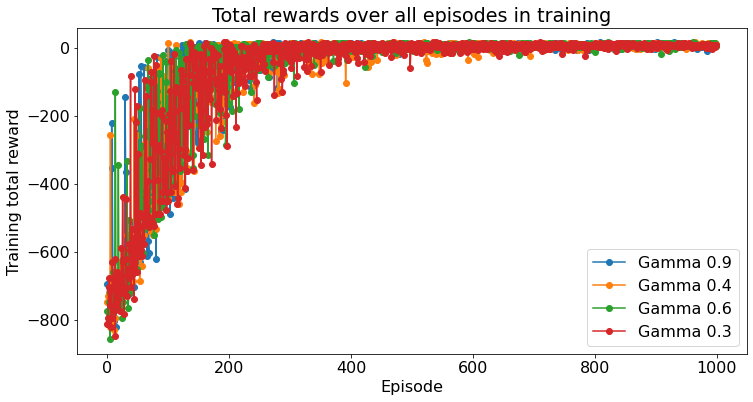

In [36]:
#Visualizing results and total reward over all episodes
train_episodes = 1000
x = range(train_episodes)
plt.plot(x, training_rewards_gamma_09_Q,marker='o',label='Gamma 0.9')
plt.plot(x, training_rewards_gamma_08_Q,marker='o',label='Gamma 0.4')
plt.plot(x, training_rewards_gamma_06_Q,marker='o',label='Gamma 0.6')
plt.plot(x, training_rewards_gamma_04_Q,marker='o',label='Gamma 0.3')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [37]:
training_rewards_alpha_09_Q,training_times_alpha_09_Q,Q_09_Q =Q_func(0.9,0.01,0.9)
training_rewards_alpha_08_Q,training_times_alpha_08_Q,Q_08_Q =Q_func(0.9,0.01,0.5)
training_rewards_alpha_01_Q,training_times_alpha_01_Q,Q_01_Q =Q_func(0.9,0.01,0.1)
training_rewards_alpha_001_Q,training_times_alpha_001_Q,Q_001_Q =Q_func(0.9,0.01,0.01)

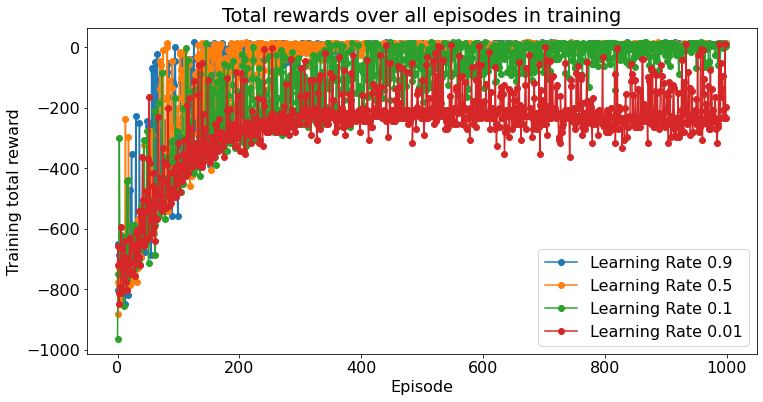

In [39]:
#Visualizing results and total reward over all episodes
train_episodes = 1000
x = range(train_episodes)
plt.plot(x, training_rewards_alpha_09_Q,marker='o',label='Learning Rate 0.9')
plt.plot(x, training_rewards_alpha_08_Q,marker='o',label='Learning Rate 0.5')
plt.plot(x, training_rewards_alpha_01_Q,marker='o',label='Learning Rate 0.1')
plt.plot(x, training_rewards_alpha_001_Q,marker='o',label='Learning Rate 0.01')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [40]:
training_rewards_decay_001_Q,training_times_decay_001_Q,Q_001_Q =Q_func(0.9,0.01,0.7)
training_rewards_decay_005_Q,training_times_decay_005_Q,Q_005_Q =Q_func(0.9,0.05,0.7)
training_rewards_decay_01_Q,training_times_decay_01_Q,Q_01_Q =Q_func(0.9,0.1,0.7)
training_rewards_decay_099_Q,training_times_decay_099_Q,Q_099_Q =Q_func(0.9,0.99,0.7)

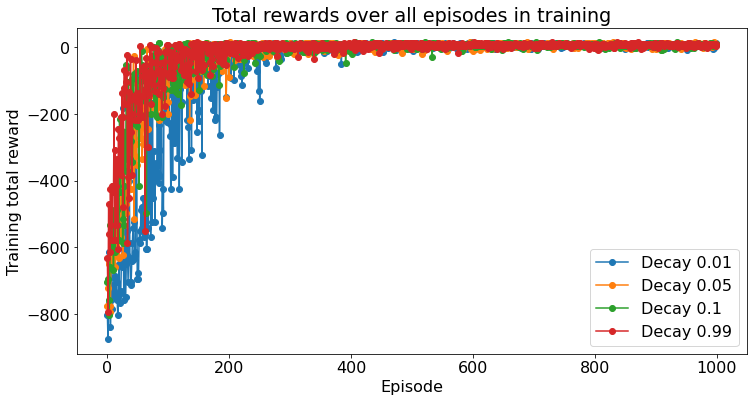

In [41]:
#Visualizing results and total reward over all episodes
train_episodes = 1000
x = range(train_episodes)
plt.plot(x, training_rewards_decay_001_Q,marker='o',label='Decay 0.01')
plt.plot(x, training_rewards_decay_005_Q,marker='o',label='Decay 0.05')
plt.plot(x, training_rewards_decay_01_Q,marker='o',label='Decay 0.1')
plt.plot(x, training_rewards_decay_099_Q,marker='o',label='Decay 0.99')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [42]:
env.reset()
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, np.argmax(Q_09_Q, axis=1), random = False)

In [43]:
print(f'Total wins with Policy iteration: {wins}')
print(f"Average rewards with Policy iteration: {avg_reward}")

Total wins with Policy iteration: 9806
Average rewards with Policy iteration: 3.8499


### Taxi 2520 States

In [44]:
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np

In [45]:
MAP = [
    "+-----------------+",
    "|R: | : : : : |G: |",
    "| : | : : : : | : |",
    "| : : : : : | | | |",
    "| | : : : | : | | |",
    "| : : | : | : : | |",
    "| : : : | : | : : |",
    "| : : : : | : : | |",
    "| : : | : | | : : |",
    "| : | : : | : : | |",
    "| : : : : : : | : |",
    "| | : : : | : | | |",
    "|Y| : |B| : : : | |",
    "| | | : : | : : | |",
    "| : : | : : | : : |",
    "+-----------------+",
]

In [46]:
class TaxiEnv2(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
    Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
    Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 404 reachable discrete states.
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    
    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (0, 7), (11, 0), (11, 3)]

        num_states = 2520
        num_rows = 14
        num_columns = 9
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)
                            
                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if pass_idx < 4 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            P[state][action].append((1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib
        )

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 9
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 9)
        i = i // 9
        out.append(i)
        assert 0 <= i < 14
        return reversed(out)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode("utf-8") for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x
        
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")
            
        # No need to return anything for human
        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [47]:
gym.register(
    id="Taxi-v4",
    entry_point=TaxiEnv2, # optimum = 8.46
    max_episode_steps=200,
)
env = gym.make('Taxi-v4')
# env=TaxiEnv

In [48]:
print(0.9)  
rewards_vi_2=[]
run_time_vi_2=[]
itr_vi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_vi_2, opt_policy_vi_2 = value_iteration(env.env, discount_factor = 0.9, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_vi_2, random = False)
    rewards_vi_2.append(avg_reward)
    run_time_vi_2.append(elapsed_time)
    itr_vi_2.append(i)
    
print(0.8)  
rewards_gamma_08_vi_2=[]
run_time_gamma_08_vi_2=[]
itr_gamma_08_vi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_08_vi_2, opt_policy_gamma_08_vi_2 = value_iteration(env.env, discount_factor = 0.8, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_08_vi_2, random = False)
    rewards_gamma_08_vi_2.append(avg_reward)
    run_time_gamma_08_vi_2.append(elapsed_time)
    itr_gamma_08_vi_2.append(i)
    
print(0.6)      
rewards_gamma_06_vi_2=[]
run_time_gamma_06_vi_2=[]
itr_gamma_06_vi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_06_vi_2, opt_policy_gamma_06_vi_2 = value_iteration(env.env, discount_factor = 0.6, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_06_vi_2, random = False)
    rewards_gamma_06_vi_2.append(avg_reward)
    run_time_gamma_06_vi_2.append(elapsed_time)
    itr_gamma_06_vi_2.append(i)
    
print(0.4)   
rewards_gamma_04_vi_2=[]
run_time_gamma_04_vi_2=[]
itr_gamma_04_vi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_04_vi_2, opt_policy_gamma_04_vi_2 = value_iteration(env.env, discount_factor = 0.4, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_04_vi_2, random = False)
    rewards_gamma_04_vi_2.append(avg_reward)
    run_time_gamma_04_vi_2.append(elapsed_time)
    itr_gamma_04_vi_2.append(i)

0.9
0.8
0.6
0.4


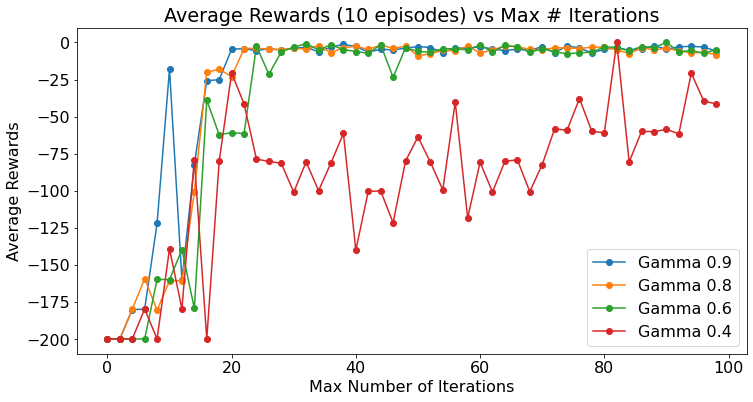

In [49]:
plt.plot(itr_vi_2,rewards_vi_2,marker='o', label='Gamma 0.9')
plt.plot(itr_vi_2,rewards_gamma_08_vi_2,marker='o', label='Gamma 0.8')
plt.plot(itr_vi_2,rewards_gamma_06_vi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_vi_2,rewards_gamma_04_vi_2,marker='o', label='Gamma 0.4')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

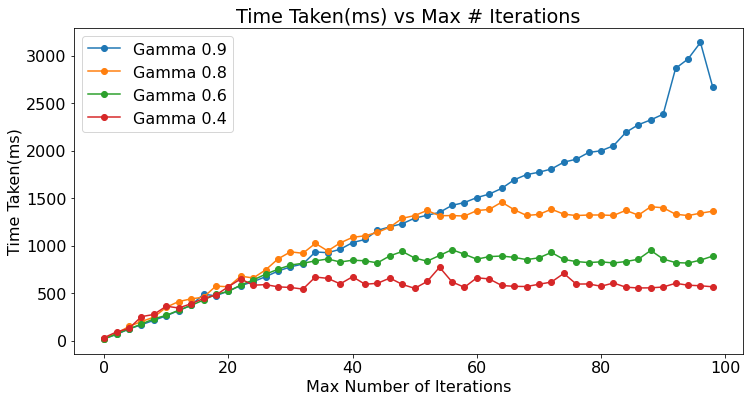

In [50]:
plt.plot(itr_vi_2,run_time_vi_2,marker='o', label='Gamma 0.9')
plt.plot(itr_vi_2,run_time_gamma_08_vi_2,marker='o', label='Gamma 0.8')
plt.plot(itr_vi_2,run_time_gamma_06_vi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_vi_2,run_time_gamma_04_vi_2,marker='o', label='Gamma 0.4')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

In [51]:
env.reset()
opt_V, opt_policy_vi_2 = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.9)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_vi_2, random = False)
print('Gamma:0.9')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.9
Total wins with value iteration: 10000
Average rewards with value iteration: -4.3416


In [52]:
env.reset()
opt_V, opt_policy_gamma_08_vi_2 = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.8)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_08_vi_2, random = False)
print('Gamma:0.8')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.8
Total wins with value iteration: 10000
Average rewards with value iteration: -4.3262


In [53]:
env.reset()
opt_V, opt_policy_gamma_06_vi_2 = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.6)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_06_vi_2, random = False)
print('Gamma:0.6')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.6
Total wins with value iteration: 9985
Average rewards with value iteration: -4.4239


In [54]:
env.reset()
opt_V, opt_policy_gamma_04_vi_2 = value_iteration(env.env, max_iteration = 100000, discount_factor = 0.4)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_04_vi_2, random = False)
print('Gamma:0.4')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Gamma:0.4
Total wins with value iteration: 6098
Average rewards with value iteration: -78.5679


### Policy Iteration

In [55]:
def policy_eval(env, policy, V, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to evaluate.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state following a given policy and state-value 'V'. 
        
    """
    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [56]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        new_policy: Optimal policy. Vector of length nS.
        
    """
    # intialize the state-Value function
    V = np.zeros(env.nS)
    
    # intialize a random policy
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        # evaluate given policy
        V = policy_eval(env, policy, V, discount_factor)
        
        # improve policy
        policy = update_policy(env, policy, V, discount_factor)
        
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
#                 print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
            

            
    return V, policy

In [57]:
print(0.9)  
rewards_pi_2=[]
run_time_pi_2=[]
itr_pi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_pi_2, opt_policy_pi_2 = policy_iteration(env.env, discount_factor = 0.9, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_pi_2, random = False)
    rewards_pi_2.append(avg_reward)
    run_time_pi_2.append(elapsed_time)
    itr_pi_2.append(i)
    
print(0.8)  
rewards_gamma_08_pi_2=[]
run_time_gamma_08_pi_2=[]
itr_gamma_08_pi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_08_pi_2, opt_policy_gamma_08_pi_2 = policy_iteration(env.env, discount_factor = 0.8, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_08_pi_2, random = False)
    rewards_gamma_08_pi_2.append(avg_reward)
    run_time_gamma_08_pi_2.append(elapsed_time)
    itr_gamma_08_pi_2.append(i)
    
print(0.6)      
rewards_gamma_06_pi_2=[]
run_time_gamma_06_pi_2=[]
itr_gamma_06_pi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_06_pi_2, opt_policy_gamma_06_pi_2 = policy_iteration(env.env, discount_factor = 0.6, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_06_pi_2, random = False)
    rewards_gamma_06_pi_2.append(avg_reward)
    run_time_gamma_06_pi_2.append(elapsed_time)
    itr_gamma_06_pi_2.append(i)
    
print(0.4)   
rewards_gamma_04_pi_2=[]
run_time_gamma_04_pi_2=[]
itr_gamma_04_pi_2=[]
for i in range(0,100,2):
    env.reset()
    tic = time.time()
    opt_V_gamma_04_pi_2, opt_policy_gamma_04_pi_2 = policy_iteration(env.env, discount_factor = 0.4, max_iteration = i)
    toc = time.time()
    elapsed_time = (toc - tic) * 1000
    env.reset()
    wins, total_reward, avg_reward = play_episodes(env, 10, opt_policy_gamma_04_pi_2, random = False)
    rewards_gamma_04_pi_2.append(avg_reward)
    run_time_gamma_04_pi_2.append(elapsed_time)
    itr_gamma_04_pi_2.append(i)

0.9
0.8
0.6
0.4


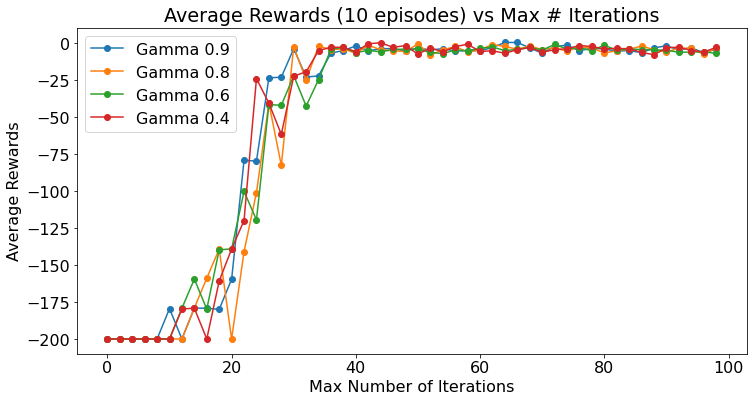

In [58]:
plt.plot(itr_pi_2,rewards_pi_2,marker='o', label='Gamma 0.9')
plt.plot(itr_pi_2,rewards_gamma_08_pi_2,marker='o', label='Gamma 0.8')
plt.plot(itr_pi_2,rewards_gamma_06_pi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_pi_2,rewards_gamma_04_pi_2,marker='o', label='Gamma 0.4')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

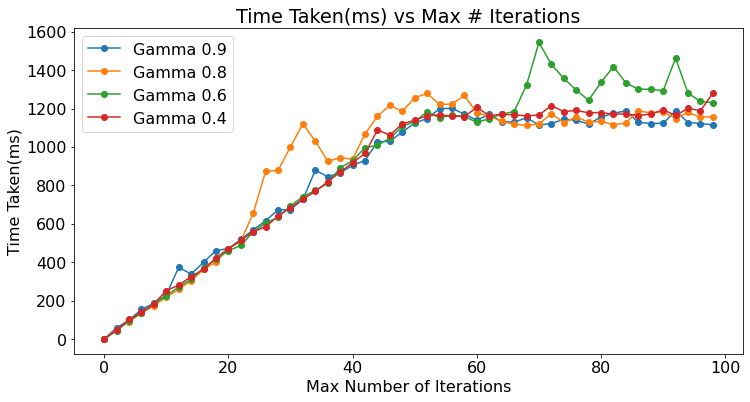

In [59]:
plt.plot(itr_pi_2,run_time_pi_2,marker='o', label='Gamma 0.9')
plt.plot(itr_pi_2,run_time_gamma_08_pi_2,marker='o', label='Gamma 0.8')
plt.plot(itr_pi_2,run_time_gamma_06_pi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_pi_2,run_time_gamma_04_pi_2,marker='o', label='Gamma 0.4')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

In [60]:
env.reset()
opt_V_pi_2, opt_policy_pi_2 = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.9)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_pi_2, random = False)
print('Gamma:0.9')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.9
Total wins with value iteration: 10000
Average rewards with policy iteration: -4.1753


In [61]:
env.reset()
opt_V_pi_2, opt_policy_gamma_08_pi_2 = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.8)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_08_pi_2, random = False)
print('Gamma:0.8')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.8
Total wins with value iteration: 10000
Average rewards with policy iteration: -4.2298


In [62]:
env.reset()
opt_V_pi_2, opt_policy_gamma_06_pi_2 = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.6)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_06_pi_2, random = False)
print('Gamma:0.6')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.6
Total wins with value iteration: 10000
Average rewards with policy iteration: -4.2153


In [63]:
env.reset()
opt_V_pi_2, opt_policy_gamma_04_pi_2 = policy_iteration(env.env, max_iteration = 100000, discount_factor = 0.4)
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, opt_policy_gamma_04_pi_2, random = False)
print('Gamma:0.4')
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with policy iteration: {avg_reward}")

Gamma:0.4
Total wins with value iteration: 10000
Average rewards with policy iteration: -4.1877


### Q Learning

In [64]:
def Q_func(discount_factor,decay,alpha):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    train_episodes = 5000    
    test_episodes = 100          
    max_steps = 100
    epsilon = 1                  
    max_epsilon = 1
    min_epsilon = 0.01    
    env.reset()
    training_rewards = []  
    epsilons = []
    training_times=[]
    init_time= time.time()
    for episode in range(train_episodes):
        #Reseting the environment each time as per requirement
        state = env.reset()    
        #Starting the tracker for the rewards
        total_training_rewards = 0
        
        for step in range(1000):
            #Choosing an action given the states based on a random number
            exp_exp_tradeoff = random.uniform(0, 1) 


            ### STEP 2: SECOND option for choosing the initial action - exploit     
            #If the random number is larger than epsilon: employing exploitation 
            #and selecting best action 
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(Q[state,:])      

            ### STEP 2: FIRST option for choosing the initial action - explore       
            #Otherwise, employing exploration: choosing a random action 
            else:
                action = env.action_space.sample()
                
            ### STEPs 3 & 4: performing the action and getting the reward     
            #Taking the action and getting the reward and outcome state
            new_state, reward, done, info = env.step(action)


            ### STEP 5: update the Q-table
            #Updating the Q-table using the Bellman equation
            prev_Q=Q.copy()
            Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state, :]) - Q[state, action]) 
            #Increasing our total reward and updating the state
            total_training_rewards += reward      
            state = new_state         

            #Ending the episode
            if done == True:
    #             print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break
        
#         if (np.all(np.equal(Q, prev_Q))):
# #                 print('Value converged at iteration %d' %(i+1))
#                 break
        #Cutting down on exploration by reducing the epsilon 
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        #Adding the total reward and reduced epsilon values
        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)
        training_times.append((time.time()-init_time)*1000)
        
        
    return training_rewards,training_times,Q
    

# print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

In [65]:
training_rewards_gamma_09_Q_2,training_times_gamma_09_Q_2,Q_09_Q_2 =Q_func(0.9,0.01,0.7)
training_rewards_gamma_08_Q_2,training_times_gamma_08_Q_2,Q_08_Q_2 =Q_func(0.8,0.01,0.7)
training_rewards_gamma_06_Q_2,training_times_gamma_06_Q_2,Q_06_Q_2 =Q_func(0.6,0.01,0.7)
training_rewards_gamma_04_Q_2,training_times_gamma_04_Q_2,Q_04_Q_2 =Q_func(0.4,0.01,0.7)

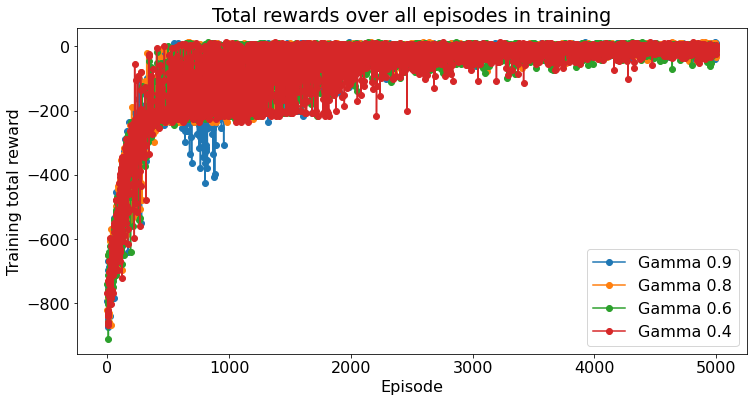

In [66]:
#Visualizing results and total reward over all episodes
train_episodes = 5000
x = range(train_episodes)
plt.plot(x, training_rewards_gamma_09_Q_2,marker='o',label='Gamma 0.9')
plt.plot(x, training_rewards_gamma_08_Q_2,marker='o',label='Gamma 0.8')
plt.plot(x, training_rewards_gamma_06_Q_2,marker='o',label='Gamma 0.6')
plt.plot(x, training_rewards_gamma_04_Q_2,marker='o',label='Gamma 0.4')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [67]:
training_rewards_alpha_09_Q_2,training_times_alpha_09_Q_2,Q_09_Q_2 =Q_func(0.9,0.01,0.9)
training_rewards_alpha_08_Q_2,training_times_alpha_08_Q_2,Q_08_Q_2 =Q_func(0.9,0.01,0.5)
training_rewards_alpha_01_Q_2,training_times_alpha_01_Q_2,Q_01_Q_2 =Q_func(0.9,0.01,0.1)
training_rewards_alpha_001_Q_2,training_times_alpha_001_Q_2,Q_001_Q_2 =Q_func(0.9,0.01,0.01)

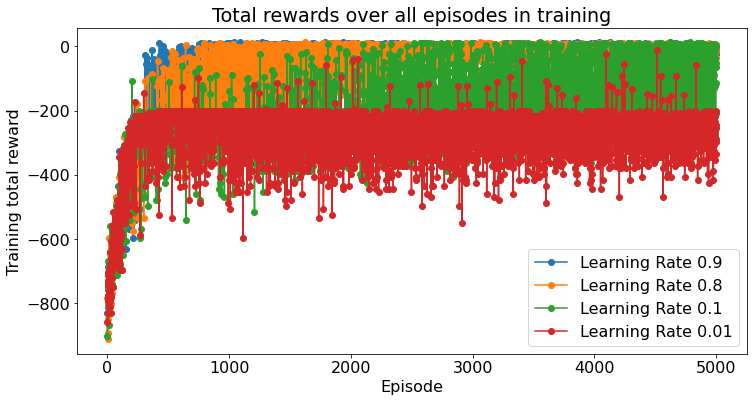

In [68]:
#Visualizing results and total reward over all episodes
train_episodes = 5000
x = range(train_episodes)
plt.plot(x, training_rewards_alpha_09_Q_2,marker='o',label='Learning Rate 0.9')
plt.plot(x, training_rewards_alpha_08_Q_2,marker='o',label='Learning Rate 0.8')
plt.plot(x, training_rewards_alpha_01_Q_2,marker='o',label='Learning Rate 0.1')
plt.plot(x, training_rewards_alpha_001_Q_2,marker='o',label='Learning Rate 0.01')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [69]:
training_rewards_decay_001_Q_2,training_times_decay_001_Q_2,Q_001_Q_2 =Q_func(0.9,0.01,0.7)
training_rewards_decay_005_Q_2,training_times_decay_05_Q_2,Q_005_Q_2 =Q_func(0.9,0.5,0.7)
training_rewards_decay_01_Q_2,training_times_decay_01_Q_2,Q_01_Q_2 =Q_func(0.9,0.1,0.7)
training_rewards_decay_099_Q_2,training_times_decay_099_Q_2,Q_099_Q_2 =Q_func(0.9,0.99,0.7)

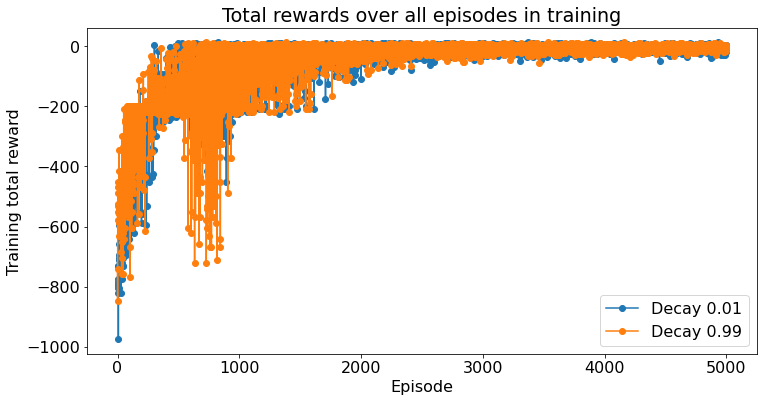

In [70]:
#Visualizing results and total reward over all episodes
train_episodes = 5000
x = range(train_episodes)
plt.plot(x, training_rewards_decay_001_Q_2,marker='o',label='Decay 0.01')
# plt.plot(x, training_rewards_decay_005_Q_2,marker='o',label='Decay 0.05')
# plt.plot(x, training_rewards_decay_01_Q_2,marker='o',label='Decay 0.1')
plt.plot(x, training_rewards_decay_099_Q_2,marker='o',label='Decay 0.99')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

### Large VS Small States

### Value Iteration

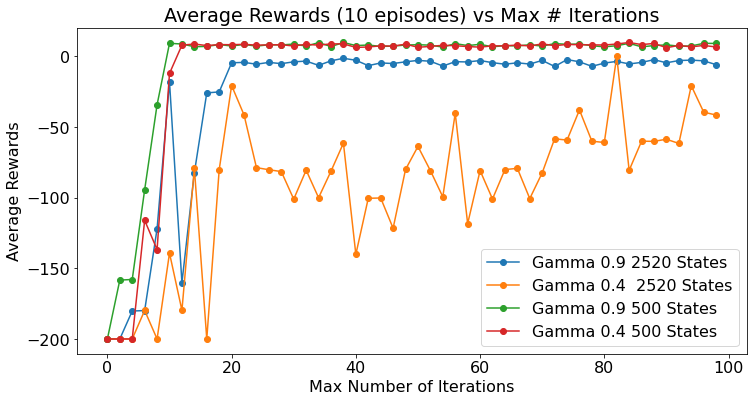

In [71]:
plt.plot(itr_vi_2,rewards_vi_2,marker='o', label='Gamma 0.9 2520 States')
# plt.plot(itr_vi_2,rewards_gamma_08_vi_2,marker='o', label='Gamma 0.8')
# plt.plot(itr_vi_2,rewards_gamma_06_vi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_vi_2,rewards_gamma_04_vi_2,marker='o', label='Gamma 0.4  2520 States')
plt.plot(itr_vi,rewards_vi,marker='o', label='Gamma 0.9 500 States')
plt.plot(itr_vi,rewards_gamma_08_vi,marker='o', label='Gamma 0.4 500 States')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

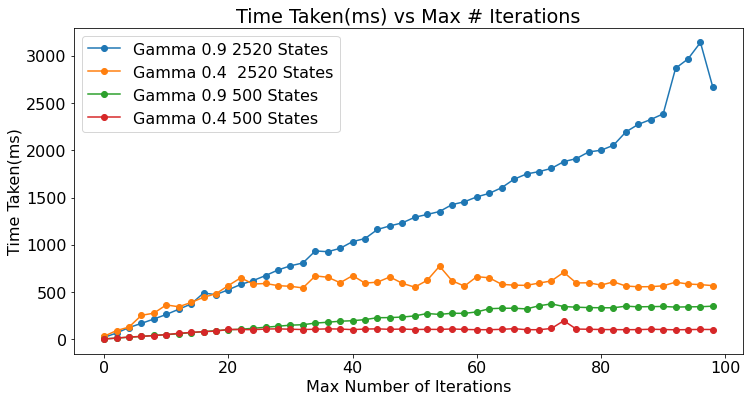

In [74]:
plt.plot(itr_vi_2,run_time_vi_2,marker='o', label='Gamma 0.9 2520 States')
# plt.plot(itr_vi_2,rewards_gamma_08_vi_2,marker='o', label='Gamma 0.8')
# plt.plot(itr_vi_2,rewards_gamma_06_vi_2,marker='o', label='Gamma 0.6')
plt.plot(itr_vi_2,run_time_gamma_04_vi_2,marker='o', label='Gamma 0.4  2520 States')
plt.plot(itr_vi,run_time_vi,marker='o', label='Gamma 0.9 500 States')
plt.plot(itr_vi,run_time_gamma_08_vi,marker='o', label='Gamma 0.4 500 States')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

### Policy Iteration

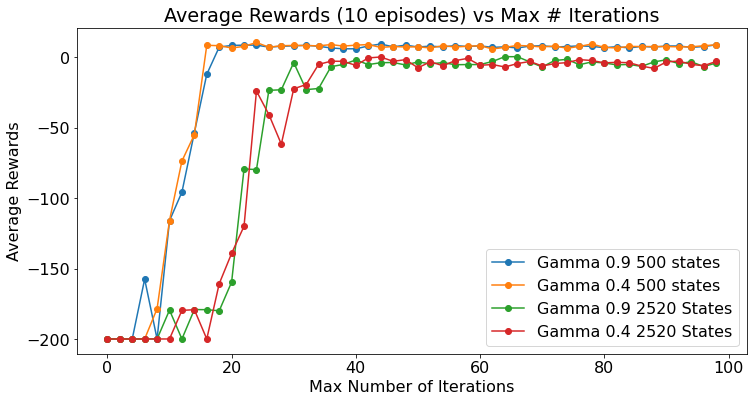

In [75]:
plt.plot(itr_pi,rewards_pi,marker='o', label='Gamma 0.9 500 states')
plt.plot(itr_pi,rewards_gamma_08_pi,marker='o', label='Gamma 0.4 500 states')
# plt.plot(itr_pi,rewards_gamma_06_pi,marker='o', label='Gamma 0.6 500 states')
# plt.plot(itr_pi,rewards_gamma_04_pi,marker='o', label='Gamma 0.1 500 states')
plt.plot(itr_pi_2,rewards_pi_2,marker='o', label='Gamma 0.9 2520 States')
# plt.plot(itr_pi_2,rewards_gamma_08_pi_2,marker='o', label='Gamma 0.8 2520 States')
# plt.plot(itr_pi_2,rewards_gamma_06_pi_2,marker='o', label='Gamma 0.6 2520 States')
plt.plot(itr_pi_2,rewards_gamma_04_pi_2,marker='o', label='Gamma 0.4 2520 States')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (10 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

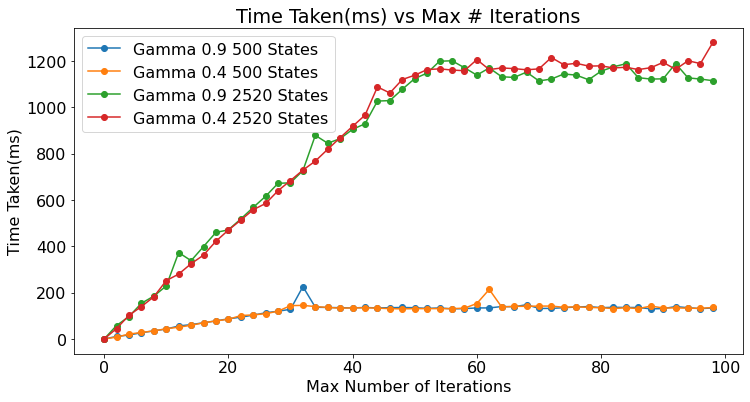

In [76]:
plt.plot(itr_pi,run_time_pi,marker='o', label='Gamma 0.9 500 States')
plt.plot(itr_pi,run_time_gamma_08_pi,marker='o', label='Gamma 0.4 500 States')
# plt.plot(itr_pi,run_time_gamma_06_pi,marker='o', label='Gamma 0.6 500 States')
# plt.plot(itr_pi,run_time_gamma_04_pi,marker='o', label='Gamma 0.1 500 States')
plt.plot(itr_pi_2,run_time_pi_2,marker='o', label='Gamma 0.9 2520 States')
# plt.plot(itr_pi_2,run_time_gamma_08_pi_2,marker='o', label='Gamma 0.8 2520 States')
# plt.plot(itr_pi_2,run_time_gamma_06_pi_2,marker='o', label='Gamma 0.6 2520 States')
plt.plot(itr_pi_2,run_time_gamma_04_pi_2,marker='o', label='Gamma 0.4 2520 States')
plt.xlabel('Max Number of Iterations')
plt.ylabel('Time Taken(ms)')
plt.title('Time Taken(ms) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

### Q Learning

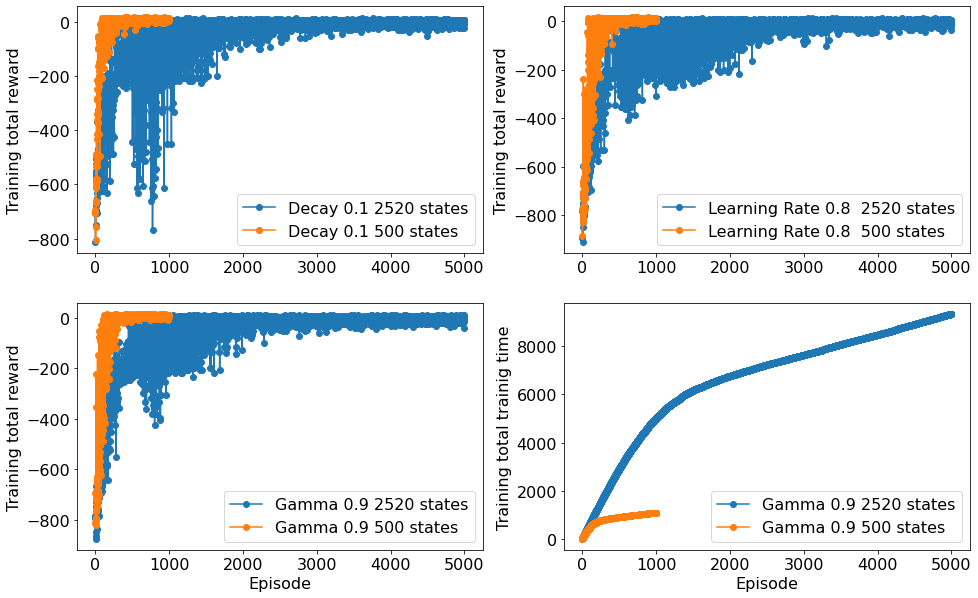

In [77]:
train_episodes = 1000
x = range(train_episodes)
x_2 = range(5000)

fig, axs = plt.subplots(2,2)
axs[0,0].plot(x_2,training_rewards_decay_01_Q_2,marker='o',label='Decay 0.1 2520 states')
axs[0,0].plot(x,training_rewards_decay_01_Q,marker='o',label='Decay 0.1 500 states')
axs[0,0].set( ylabel='Training total reward')
axs[0,0].legend()

axs[0,1].plot(x_2, training_rewards_alpha_08_Q_2,marker='o',label='Learning Rate 0.8  2520 states')
axs[0,1].plot(x, training_rewards_alpha_08_Q,marker='o',label='Learning Rate 0.8  500 states')
axs[0,1].set( ylabel='Training total reward')
axs[0,1].legend()

axs[1,0].plot(x_2, training_rewards_gamma_09_Q_2,marker='o',label='Gamma 0.9 2520 states')
axs[1,0].plot(x, training_rewards_gamma_09_Q,marker='o',label='Gamma 0.9 500 states')
axs[1,0].set( ylabel='Training total reward', xlabel='Episode')
axs[1,0].legend()

axs[1,1].plot(x_2, training_times_gamma_08_Q_2,marker='o',label='Gamma 0.9 2520 states')
axs[1,1].plot(x, training_times_gamma_08_Q,marker='o',label='Gamma 0.9 500 states')
axs[1,1].set( ylabel='Training total trainig time', xlabel='Episode')
axs[1,1].legend()



fig=plt.gcf()
fig.set_size_inches(16,10)

In [78]:
env.reset()
n_episode = 10000
wins, total_reward, avg_reward = play_episodes(env, n_episode, np.argmax(Q_09_Q_2, axis=1), random = False)

In [79]:
print(f'Total wins with Policy iteration: {wins}')
print(f"Average rewards with Policy iteration: {avg_reward}")

Total wins with Policy iteration: 9721
Average rewards with Policy iteration: -9.8482


In [80]:
# create Taxi environment
env = gym.make('Taxi-v4')

# create a new instance of taxi, and get the initial state
state = env.reset()

num_steps = 25
for s in range(num_steps+1):
    print(f"step: {s} out of {num_steps}")

    # sample a random action from the list of available actions
    action = opt_policy_vi_2[state]


    # perform this action on the environment
    next_state, reward,  terminated, info =env.step(action)
    state = next_state
    
    # print the new state
    env.render()
    if terminated == True:
#             print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
        break

# end this instance of the taxi environment
env.close()

step: 0 out of 25
+-----------------+
|R: | : : : : |G: |
| : | : : : : | : |
| : : : : : | | | |
| | : : : | : | | |
| : : | : | : : | |
| : : : | : | : : |
| : : : : | : : | |
| : : | : | | : : |
| : | : : | : : | |
| : : : : : : | : |
| | : : : | : | | |
|Y| : |B| : : : | |
| | | : : | : : | |
| : : | : : | : : |
+-----------------+
  (South)
step: 1 out of 25
+-----------------+
|R: | : : : : |G: |
| : | : : : : | : |
| : : : : : | | | |
| | : : : | : | | |
| : : | : | : : | |
| : : : | : | : : |
| : : : : | : : | |
| : : | : | | : : |
| : | : : | : : | |
| : : : : : : | : |
| | : : : | : | | |
|Y| : |B| : : : | |
| | | : : | : : | |
| : : | : : | : : |
+-----------------+
  (West)
step: 2 out of 25
+-----------------+
|R: | : : : : |G: |
| : | : : : : | : |
| : : : : : | | | |
| | : : : | : | | |
| : : | : | : : | |
| : : : | : | : : |
| : : : : | : : | |
| : : | : | | : : |
| : | : : | : : | |
| : : : : : : | : |
| | : : : | : | | |
|Y| : |B| : : : | |
| | | : : | : : | |
| : : |

### Forest Management

In [81]:
P, R = mdptoolbox.example.forest(S=5,p=0.3)
pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.95)
pi.run()
pi.policy

(0, 0, 0, 0, 0)

In [82]:
P, R = mdptoolbox.example.forest(S=5,p=0.5)
pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.95)
pi.run()
pi.policy

(0, 1, 0, 0, 0)

In [83]:
P, R = mdptoolbox.example.forest(S=5,p=0.7)
pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.95)
pi.run()
pi.policy

(0, 1, 1, 0, 0)

In [84]:
P, R = mdptoolbox.example.forest(S=5,p=0.9)
pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.95)
pi.run()
pi.policy

(0, 1, 1, 1, 0)

In [85]:
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
                    
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / test_count

def trainQLearning(P, R, test_count, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    from hiive.mdptoolbox.mdp import QLearning
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])

    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = evaluate_policy(P, R, q.policy, test_count)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

### Policy Iteration

In [86]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.PolicyIteration(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(pi.iter)
    times.append(pi.time*1000)
    return value_f,times,iters

In [88]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(2,30):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(2,30):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)

convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]

for i in range(2,30):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(2,30):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

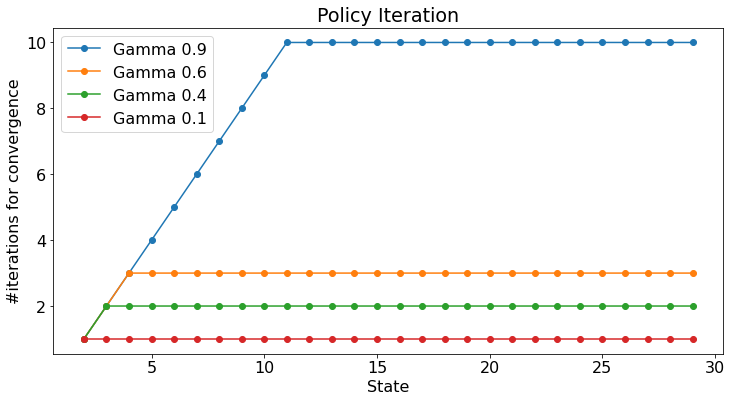

In [89]:
plt.plot(range(2,30), convergence_iters_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_iters_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_iters_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_iters_01,marker='o',label='Gamma 0.1')
plt.xlabel('State')
plt.title('Policy Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

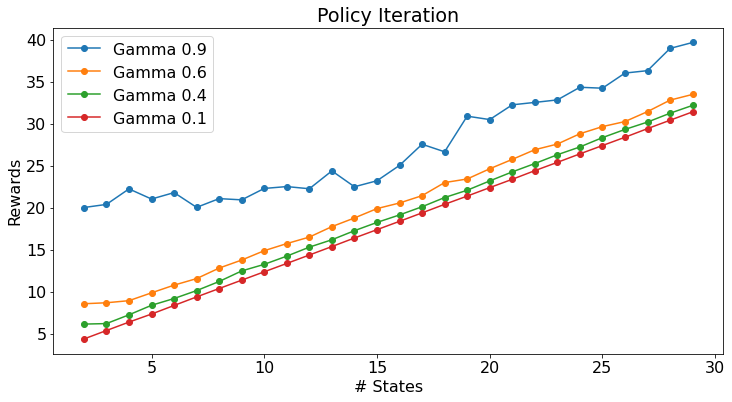

In [90]:
plt.plot(range(2,30), convergence_rewards_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_rewards_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_rewards_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_rewards_01,marker='o',label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Policy Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

### Value Iteration

In [91]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.ValueIteration(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(pi.iter)
    times.append(pi.time*1000)
    return value_f,times,iters

In [92]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(2,30):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(2,30):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)
    
convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]
for i in range(2,30):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(2,30):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

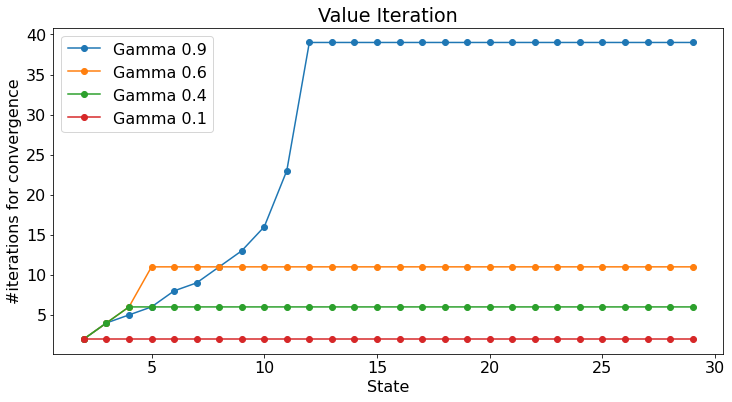

In [93]:
plt.plot(range(2,30), convergence_iters_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_iters_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_iters_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_iters_01,marker='o',label='Gamma 0.1')
plt.xlabel('State')
plt.title('Value Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

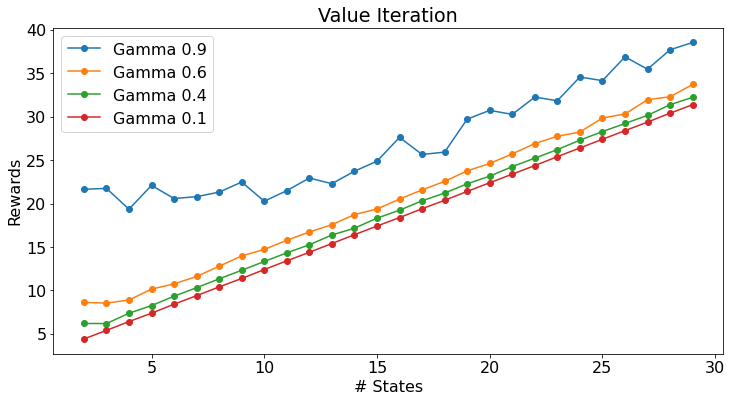

In [94]:
plt.plot(range(2,30), convergence_rewards_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_rewards_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_rewards_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_rewards_01,marker='o',label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Value Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

### Q Learning

In [95]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.QLearning(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(0)
    times.append(pi.time*1000)
    return value_f,times,iters

In [96]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(2,30):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(2,30):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)
    
convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]
for i in range(2,30):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(2,30):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

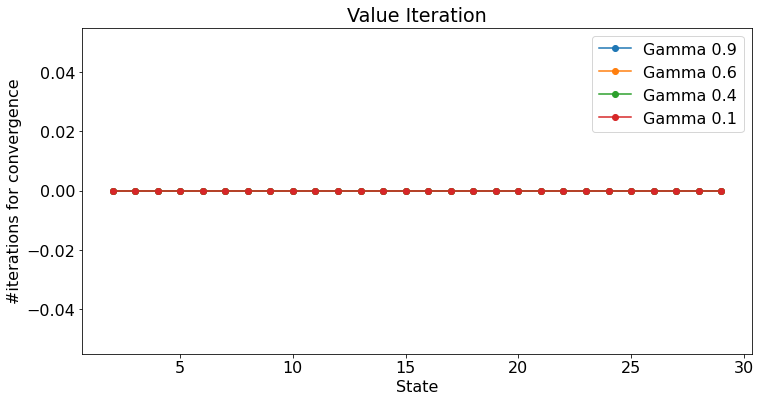

In [97]:
plt.plot(range(2,30), convergence_iters_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_iters_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_iters_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_iters_01,marker='o',label='Gamma 0.1')
plt.xlabel('State')
plt.title('Value Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

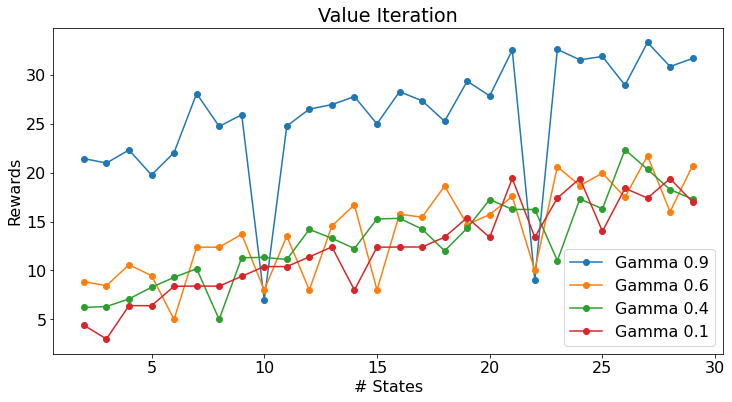

In [98]:
plt.plot(range(2,30), convergence_rewards_09,marker='o',label='Gamma 0.9')
plt.plot(range(2,30), convergence_rewards_06,marker='o',label='Gamma 0.6')
plt.plot(range(2,30), convergence_rewards_04,marker='o',label='Gamma 0.4')
plt.plot(range(2,30), convergence_rewards_01,marker='o',label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Value Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

1: 41.924392330537174
2: 39.819588689940744
3: 41.429019011053384
4: 41.692881717271014
5: 41.080495534448886
6: 7.0


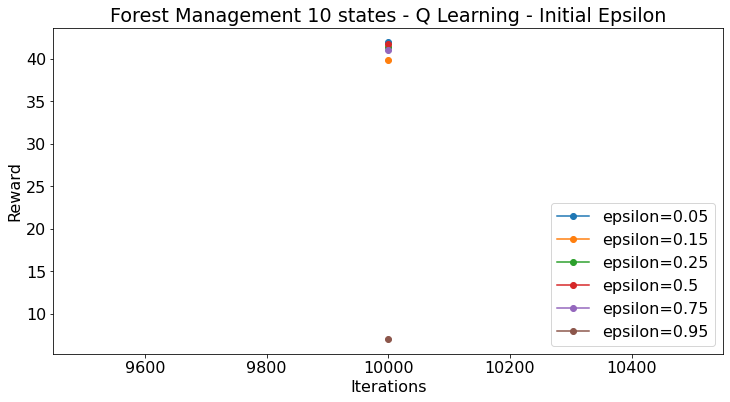

<AxesSubplot:title={'center':'Forest Management 10 - Q Learning'}, xlabel='Epsilon', ylabel='Time'>

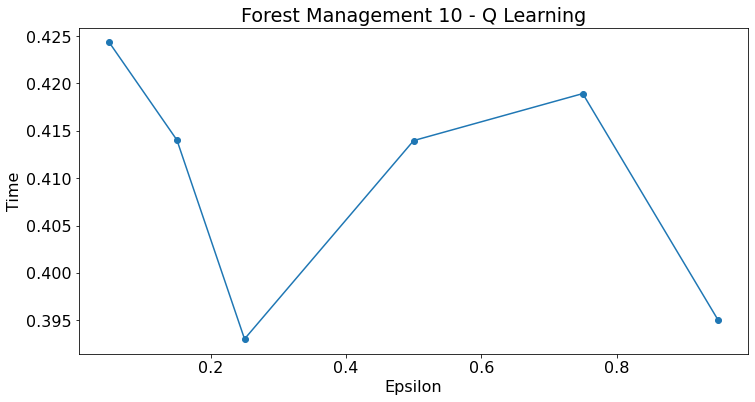

In [99]:
    P, R = mdptoolbox.example.forest(S=10,p=0.01)
    states=10
    eps = [0.05,0.15,0.25,0.5,0.75,0.95]
    iters = [10000]
    q_df = trainQLearning(P, R, 100, discount=0.9, epsilon=eps,n_iter=iters)
    
    # print('Forest Management ' + str(states) + ' states - Q-learning Table')
    # print(q_df)
    
    fig = plt.figure()
    for frame in [q_df[(q_df.Epsilon == 0.05)], q_df[(q_df.Epsilon == 0.15)], q_df[(q_df.Epsilon == 0.25)], q_df[(q_df.Epsilon == 0.50)], q_df[(q_df.Epsilon == 0.75)], q_df[(q_df.Epsilon == 0.95)]]:
        plt.plot(frame['Iterations'], frame['Reward'],marker='o')
    labels = ["epsilon=" + str(x) for x in eps]
    plt.title('Forest Management ' + str(states) + ' states - Q Learning - Initial Epsilon')
    plt.legend(labels,loc='lower right')
    plt.xlabel('Iterations')
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    plt.ylabel('Reward')
    
    plt.show()
    
    q_df[(q_df.Iterations == 10000)].plot(x='Epsilon', y='Time',legend=None,xlabel="Epsilon",ylabel="Time",title="Forest Management " + str(states) + " - Q Learning",marker='o',figsize=(12,6))

In [100]:
def run_Forest(states, test_count):
    
    # New way
    print('Q LEARNING WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states,p=0.01)
    eps = [0.05,0.15,0.25,0.5,0.75,0.95]
    iters = [10000, 100000, 1000000, 10000000]
    q_df = trainQLearning(P, R, test_count, discount=0.9, epsilon=eps, n_iter=iters)
    
    # print('Forest Management ' + str(states) + ' states - Q-learning Table')
    # print(q_df)
    
    fig = plt.figure()
    for frame in [q_df[(q_df.Epsilon == 0.05)], q_df[(q_df.Epsilon == 0.15)], q_df[(q_df.Epsilon == 0.25)], q_df[(q_df.Epsilon == 0.50)], q_df[(q_df.Epsilon == 0.75)], q_df[(q_df.Epsilon == 0.95)]]:
        plt.plot(frame['Iterations'], frame['Reward'],marker='o')
    labels = ["epsilon=" + str(x) for x in eps]
    plt.title('Forest Management ' + str(states) + ' states - Q Learning - Initial Epsilon')
    plt.legend(labels,loc='lower right')
    plt.xlabel('Iterations')
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    plt.ylabel('Reward')
    
    plt.show()
    
    q_df[(q_df.Iterations == 10000000)].plot(x='Epsilon', y='Time',legend=None,xlabel="Epsilon",ylabel="Time",title="Forest Management " + str(states) + " - Q Learning",marker='o',figsize=(12,6))
    
    return

STARTING FOREST MANAGEMENT 20 STATES
Q LEARNING WITH FOREST MANAGEMENT 20 STATES 
1: 45.24211989978661
2: 47.76063184064802
3: 48.720010552095374
4: 47.82435093823656
5: 46.69610145520995
6: 44.519250827958714
7: 51.546167812214705
8: 48.95881363743268
9: 52.116993025815006
10: 51.784497965019206
11: 53.74245528609918
12: 53.69961824073285
13: 50.60512333487862
14: 50.39678438818022
15: 53.28024407240967
16: 51.79095844874571
17: 54.62540734468466
18: 53.96414157806746
19: 51.843938992171545
20: 51.61621641706534
21: 17.0
22: 52.64759682238099
23: 19.0
24: 51.775920378591714


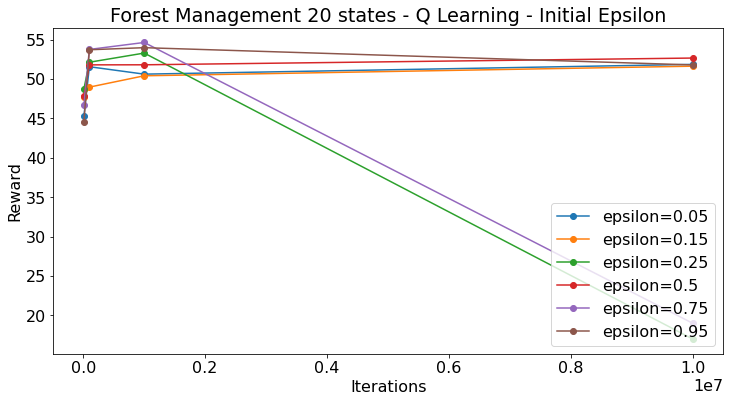

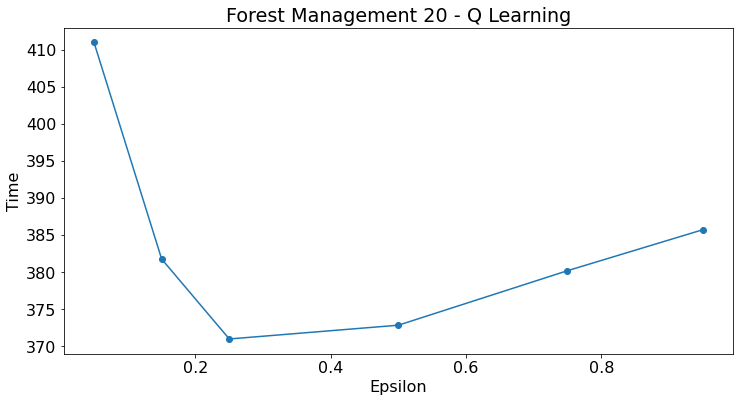

In [101]:
print('STARTING FOREST MANAGEMENT 20 STATES')
run_Forest(20, 1000) # States, test_count